<a href="https://colab.research.google.com/github/1aaronscott/DS-Unit-2-Regression-Classification/blob/master/module3/213_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [x] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [x] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [x] Do feature selection with `SelectKBest`.
- [x] Fit a linear regression model with multiple features.
- [x] Get mean absolute error for the test set.
- [x] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [3]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 3.4MB/s 
     |████████████████████████████████| 133kB 9.1MB/s 
     |████████████████████████████████| 7.1MB 40.6MB/s 
     |████████████████████████████████| 614kB 34.4MB/s 
     |████████████████████████████████| 225kB 40.1MB/s 
     |████████████████████████████████| 768kB 35.5MB/s 
     |████████████████████████████████| 194kB 35.4MB/s 
     |████████████████████████████████| 51kB 16.7MB/s 
     |████████████████████████████████| 737kB 36.2MB/s 
     |████████████████████████████████| 51kB 18.2MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=4d1c77812f6fb027e28a6fe5afc29ca41fea269d4d18a15f406d0dc49afc8d94
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=583b30030c7306d6f63e0283e647fa1628d2b27bf7333131f84f53386969e718
  Stored 

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 50 (delta 0), reused 6 (delta 0), pack-reused 42
Unpacking objects: 100% (50/50), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
df.head(20)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019
5,1,UPPER EAST SIDE (79-96),07 RENTALS - WALKUP APARTMENTS,2B,1551,131,NaN,C4,354 EAST 89TH STREET,NaN,10128.0,10.0,0.0,10.0,"2,013",6570.0,1920.0,2,C4,0,01/01/2019
6,1,UPPER WEST SIDE (96-116),07 RENTALS - WALKUP APARTMENTS,2B,1891,159,NaN,C4,304 WEST 106 STREET,NaN,10025.0,10.0,0.0,10.0,"1,716",5810.0,1900.0,2,C4,0,01/01/2019
7,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4090,37,NaN,A1,1193 SACKET AVENUE,NaN,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,01/01/2019
8,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4120,18,NaN,A5,1215 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
9,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4120,20,NaN,A5,1211 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019


In [9]:
# df[['BUILDING_CLASS_CATEGORY' == '01 ONE FAMILY DWELLINGS']]
df.query('BUILDING_CLASS_CATEGORY == "01 ONE FAMILY DWELLINGS"').shape


(5061, 21)

In [0]:
df['BUILDING_CLASS_CATEGORY'].unique()

In [0]:
#limit dataframe to ONE FAMILY DWELLINGS
df2 = df.query('BUILDING_CLASS_CATEGORY == "01 ONE FAMILY DWELLINGS"')

In [17]:
df2.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [7]:
#convert sale_date to datetime data type
df2.SALE_DATE = pd.to_datetime(df2.SALE_DATE, infer_datetime_format=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [19]:
df2.SALE_DATE.describe()

count                    5061
unique                    119
top       2019-01-31 00:00:00
freq                       96
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [0]:
#drop easement and apartment number columns
df2 = df2.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER'])

In [44]:
df2.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [9]:
#split the dataframe into train and test dataframes
datecut = pd.to_datetime('2019-04-01')
train = df2[df2['SALE_DATE'] < datecut]
test  = df2[df2['SALE_DATE'] >= datecut]
df2.shape, train.shape, test.shape            

((5061, 19), (4094, 19), (967, 19))

In [43]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
7,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4090,37,A1,1193 SACKET AVENUE,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,2019-01-01
8,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4120,18,A5,1215 VAN NEST AVENUE,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,2019-01-01
9,2,MORRIS PARK/VAN NEST,01 ONE FAMILY DWELLINGS,1,4120,20,A5,1211 VAN NEST AVENUE,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,2019-01-01
42,3,MADISON,01 ONE FAMILY DWELLINGS,1,6809,54,A1,2601 AVENUE R,11229.0,1.0,0.0,1.0,"3,333",1262.0,1925.0,1,A1,0,2019-01-01
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

BOROUGH 5


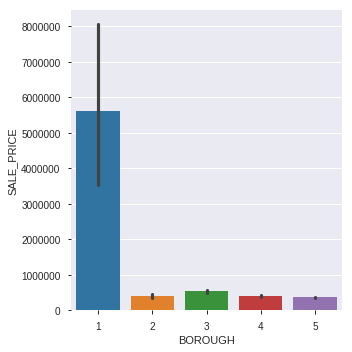

NEIGHBORHOOD 209
BUILDING_CLASS_CATEGORY 1


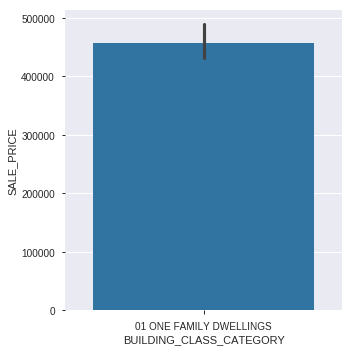

TAX_CLASS_AT_PRESENT 3


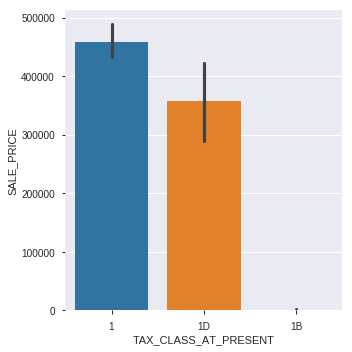

BLOCK 3115
LOT 360
BUILDING_CLASS_AT_PRESENT 15
ADDRESS 4059
ZIP_CODE 147
RESIDENTIAL_UNITS 2


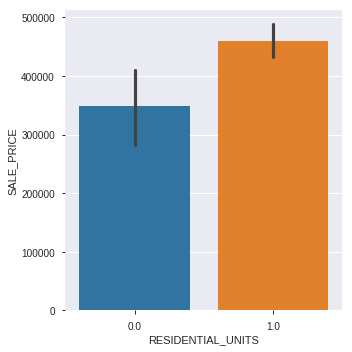

COMMERCIAL_UNITS 3


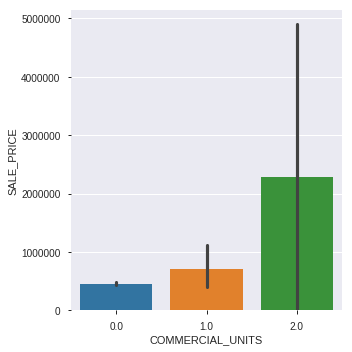

TOTAL_UNITS 4


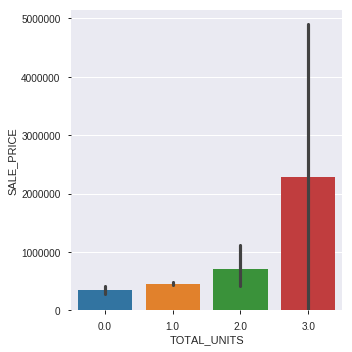

LAND_SQUARE_FEET 1280
GROSS_SQUARE_FEET 1292
YEAR_BUILT 94
TAX_CLASS_AT_TIME_OF_SALE 1


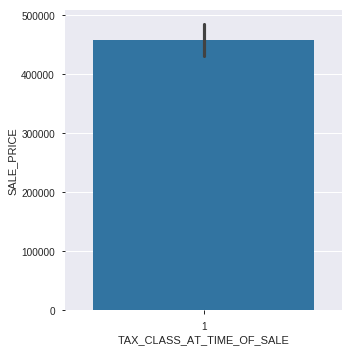

BUILDING_CLASS_AT_TIME_OF_SALE 12
SALE_PRICE 973
SALE_DATE 90


In [45]:
for columns in train:
  print(columns, train[columns].nunique())
  if train[columns].nunique() < 12:
    sns.catplot(x=columns, y='SALE_PRICE', data=train, kind='bar')
    plt.show()

In [46]:
train.describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,4094,4094,4094,4094,4094,4094,4094,4094
unique,209,1,3,15,4059,1280,12,90
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,1634 59TH STREET,"4,000",A1,2019-03-29 00:00:00
freq,147,4094,4058,1542,3,412,1543,96
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-31 00:00:00


In [47]:
train.describe()

,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.0,4.094000e+03
mean,3.866146,6665.769419,72.974841,11012.498534,0.991451,0.024670,1.016121,1571.044944,1943.012702,1.0,4.579418e+05
std,0.902077,3911.046025,152.843450,516.706900,0.092076,0.159792,0.185562,754.804640,40.361466,0.0,8.885199e+05
min,1.000000,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000e+00
25%,3.000000,3811.000000,20.250000,10453.000000,1.000000,0.000000,1.000000,1170.000000,1925.000000,1.0,0.000000e+00
50%,4.000000,6026.500000,42.000000,11234.000000,1.000000,0.000000,1.000000,1408.000000,1940.000000,1.0,4.146935e+05
75%,4.000000,9501.750000,69.000000,11413.000000,1.000000,0.000000,1.000000,1785.750000,1955.000000,1.0,6.300000e+05
max,5.000000,16350.000000,2720.000000,11697.000000,1.000000,2.000000,3.000000,12618.000000,2018.000000,1.0,3.013936e+07


In [54]:
test.describe()

,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.0,9.670000e+02
mean,3.691830,7413.739400,73.077559,11161.644261,0.988625,0.014478,1.003102,1509.700103,1938.940021,1.0,5.306939e+05
std,0.799952,3833.985171,172.793170,406.949577,0.115447,0.119511,0.167155,673.457994,23.521157,0.0,1.081712e+06
min,1.000000,107.000000,1.000000,10011.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,0.000000e+00
25%,3.000000,4587.000000,21.000000,11209.000000,1.000000,0.000000,1.000000,1152.000000,1925.000000,1.0,0.000000e+00
50%,4.000000,7267.000000,40.000000,11361.000000,1.000000,0.000000,1.000000,1356.000000,1930.000000,1.0,4.790000e+05
75%,4.000000,10549.000000,67.000000,11418.000000,1.000000,0.000000,1.000000,1712.000000,1950.000000,1.0,6.800000e+05
max,5.000000,16350.000000,2780.000000,11697.000000,2.000000,1.000000,2.000000,8876.000000,2018.000000,1.0,2.150000e+07


In [12]:
#one-hot encode boroughs 

#convert to strings
train['BOROUGH'] = train['BOROUGH'].astype(str)
# test['BOROUGH'] = test['BOROUGH'].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
import category_encoders as ce

In [16]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['BOROUGH'])
encoded.head()

,BOROUGH
7,2
8,2
9,2
42,3
44,3


In [0]:
# https://lambdaschoolstudents.slack.com/archives/GHG1KGWHH/p1565214244339700
# # BOROUGH is a numeric column, but arguably should be a categorical feature,
# # so convert it from a number to a string
# train['BOROUGH'] = train['BOROUGH'].astype(str)
# test['BOROUGH'] = test['BOROUGH'].astype(str)


# # Reduce cardinality for NEIGHBORHOOD feature ...

# # Get a list of the top 10 neighborhoods
# top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# # At locations where the neighborhood is NOT in the top 10,
# # replace the neighborhood with 'OTHER'
# train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
# test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
# https://lambdaschoolstudents.slack.com/archives/GHG1KGWHH/p1565216333345100
# # Which features were used?
# k = 15
# selector = SelectKBest(score_func=f_regression, k=k)
# X_train_selected = selector.fit_transform(X_train_scaled, y_train)

# all_names = X_train_encoded.columns
# selected_mask = selector.get_support()
# selected_names = all_names[selected_mask]
# unselected_names = all_names[~selected_mask]

# print('Features selected:')
# for name in selected_names:
#     print(name)

# print('\nFeatures not selected:')
# for name in unselected_names:
#     print(name)

In [11]:
#following quick baseline example from lecture
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4094, 10), (4094,), (967, 10), (967,))

In [12]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_test_selected.shape, X_train_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((967, 10), (4094, 10))

In [13]:
#finding selected features
column_mask = selector.get_support()
all_columns = X_train.columns
chosen_names = all_columns[column_mask]
discard_names = all_columns[~column_mask]
print("Chosen features:", chosen_names, "\n\n", "Discared features: ", discard_names)

Chosen features: Index(['BOROUGH', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object') 

 Discared features:  Index([], dtype='object')


In [19]:
#performance of selected features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, rmse, mae, r2
# print("RMSE: ", rmse, "MAE: ", mae, "R^2: ", r2, sep='\n')
print(f"""
RMSE: {rmse}
MAE: {mae}
R^2: {r2}
""")

RMSE: 
940740.4865136922
MAE: 
416772.2668066063
R^2: 
0.2428781483377066

RMSE: 940740.4865136922
MAE: 416772.2668066063
R^2: 0.2428781483377066

